In this analysis, it was used the data made available by the **Infodengue** (https://info.dengue.mat.br/) . It was used the data until the end of the 2021 year for the Recife city. 

The data is saved in the data folder. It was named as: `{disease}_{ibge_code}.csv` and assigned with `cluster` in the end when it refers to the clustered data. 

Let's look at the dengue and chik data for this case. Note that we have some statistics related to humidity, temperature, and the number of cases. These features will be used to forecast the number of dengue cases reported. 

In [1]:
import os 
import pickle
os.chdir('../')
import pandas as pd
from pgbm import qf_prediction
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from pgbm import  cross_dengue_chik_prediction
from sklearn.metrics import mean_squared_error as mse 

In [2]:
city = 2611606
city_name = 'Recife'
df_dengue = pd.read_csv(f'./data/dengue_{city}.csv', index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2611606,casos_est_2611606,casos_est_min_2611606,casos_est_max_2611606,p_rt1_2611606,p_inc100k_2611606,temp_min_2611606,temp_max_2611606,umid_min_2611606,pressao_min_2611606
2010-01-03,3,3.0,3,3,0.000000,0.181438,25.000000,29.666667,56.666667,1009.666667
2010-01-10,1,1.0,1,1,0.000000,0.060479,25.000000,29.428571,59.142857,1010.142857
2010-01-17,2,2.0,2,2,0.000000,0.120958,25.000000,29.142857,63.000000,1011.571429
2010-01-24,1,1.0,1,1,0.000000,0.060479,24.142857,29.000000,67.000000,1010.714286
2010-01-31,0,0.0,0,0,0.000000,0.000000,24.857143,30.000000,56.714286,1009.142857
...,...,...,...,...,...,...,...,...,...,...
2022-05-29,71,95.0,77,134,0.468386,5.745524,23.000000,27.428571,77.831345,1012.571429
2022-06-05,75,105.0,83,154,0.768051,6.350316,23.571429,28.000000,77.063711,1010.714286
2022-06-12,41,82.0,53,160,0.149694,4.959294,23.000000,26.857143,77.824348,1012.000000
2022-06-19,35,91.0,49,204,0.382086,5.503607,23.285714,28.428571,66.299810,1013.142857


Note that the chik dataset has the same columns

In [3]:
df_chik = pd.read_csv(f'./data/chik_{city}.csv', index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_2611606,casos_est_2611606,casos_est_min_2611606,casos_est_max_2611606,p_rt1_2611606,p_inc100k_2611606,temp_min_2611606,temp_max_2611606,umid_min_2611606,pressao_min_2611606
2010-01-03,0,0.0,0,0.0,0.000000,0.000000,25.000000,29.666667,56.666667,1009.666667
2010-01-10,0,0.0,0,0.0,0.000000,0.000000,25.000000,29.428571,59.142857,1010.142857
2010-01-17,0,0.0,0,0.0,0.000000,0.000000,25.000000,29.142857,63.000000,1011.571429
2010-01-24,0,0.0,0,0.0,0.000000,0.000000,24.142857,29.000000,67.000000,1010.714286
2010-01-31,0,0.0,0,0.0,0.000000,0.000000,24.857143,30.000000,56.714286,1009.142857
...,...,...,...,...,...,...,...,...,...,...
2022-05-29,41,54.5,44,53.0,0.427148,3.296116,23.000000,27.428571,77.831345,1012.571429
2022-06-05,27,44.0,31,53.0,0.300840,2.661085,23.571429,28.000000,77.063711,1010.714286
2022-06-12,18,38.0,22,53.0,0.144230,2.298210,23.000000,26.857143,77.824348,1012.000000
2022-06-19,15,41.0,20,53.0,0.344311,2.479647,23.285714,28.428571,66.299810,1013.142857


The main difference between the datasets above and the datasets with names ended with `cluster` is the number of columns. This dataset has columns with data from other cities. The city is identified by a 7-number code. These cities was clusterized with Recife (in this case) using a hierarchical clusterization algorithm. 

In [4]:
df_chik_cluster = pd.read_csv(f'./data/chik_{city}_cluster.csv', index_col = 'Unnamed: 0' )
df_chik_cluster.index = pd.to_datetime(df_chik_cluster.index)
df_chik_cluster

,casos_2614857,casos_est_2614857,casos_est_min_2614857,casos_est_max_2614857,p_rt1_2614857,p_inc100k_2614857,temp_min_2614857,temp_max_2614857,umid_min_2614857,pressao_min_2614857,...,casos_2613800,casos_est_2613800,casos_est_min_2613800,casos_est_max_2613800,p_rt1_2613800,p_inc100k_2613800,temp_min_2613800,temp_max_2613800,umid_min_2613800,pressao_min_2613800
2010-01-03,0,0.0,0,0,0.000000,0.000000,21.666667,29.666667,54.333333,1010.666667,...,0,0.0,0,0,0.000000,0.000000,22.666667,31.333333,48.000000,1010.666667
2010-01-10,0,0.0,0,0,0.000000,0.000000,22.000000,29.428571,53.142857,1010.714286,...,0,0.0,0,0,0.000000,0.000000,22.000000,30.857143,46.571429,1011.000000
2010-01-17,0,0.0,0,0,0.000000,0.000000,22.714286,29.857143,55.142857,1012.428571,...,0,0.0,0,0,0.000000,0.000000,22.142857,30.571429,46.857143,1012.714286
2010-01-24,0,0.0,0,0,0.000000,0.000000,21.142857,27.571429,62.142857,1011.285714,...,0,0.0,0,0,0.000000,0.000000,21.714286,30.285714,48.142857,1011.571429
2010-01-31,0,0.0,0,0,0.000000,0.000000,23.000000,30.000000,58.142857,1010.142857,...,0,0.0,0,0,0.000000,0.000000,22.428571,31.142857,49.000000,1010.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29,0,0.0,0,0,0.000000,0.000000,21.857143,27.000000,71.480463,1014.142857,...,11,11.0,11,14,0.232316,60.823887,20.285714,25.428571,76.269180,1015.000000
2022-06-05,2,2.0,2,2,0.921897,8.466325,22.142857,27.000000,74.248846,1011.857143,...,0,0.0,0,3,0.000000,0.000000,20.857143,26.142857,74.331669,1013.000000
2022-06-12,1,1.0,1,1,0.663458,4.233162,21.714286,26.285714,74.289160,1013.142857,...,1,1.0,1,5,0.003296,5.529444,20.000000,24.714286,76.677290,1014.142857
2022-06-19,0,0.0,0,0,0.000000,0.000000,21.571429,25.571429,74.774812,1014.428571,...,0,0.0,0,7,0.000000,0.000000,20.000000,26.000000,71.428282,1015.428571


We need to have this kind of data because, in our tests, the gradient boosting tree model perform betters when using the cluster data, while the neural network model performed better using only the city's data. 

Let's plot this two incidence curver (dengue and chik):

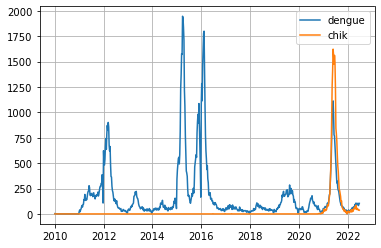

In [5]:
fig, ax = plt.subplots()

ax.plot(df_dengue[f'casos_est_{city}'], label = 'dengue')

ax.plot(df_chik[f'casos_est_{city}'], label = 'chik')

plt.legend()
plt.grid()
plt.show()

### Neural network model (NN)

First, we make the prediction using the data up to 2022-01-01 and use 25% data to test the model. It used 25% of the training data as validation data. It used the early stop config to train the model faster to monitor the loss function. 

Before applying the nn model we compute the first derivative of our target (the incidence curve) and added it as a feature. 

The neural newtork model is constructed using the `build_model` function. This function create a model with a bidirectional LSTM layer and a simple LSTM layer. We use the last 4 (look_back parameter) observations to predict the next 4 (predict_n parameter). 

The predictions of this models are saved in the path:
'./predictions/lstm/lstm_{city}_dengue_{label}.pkl'

The model is saved in the path: 
'./saved_models/lstm/trained_{geocode}_model_{label}.h5'

Compilation Time :  0.030845165252685547
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
________________

2022-08-17 16:25:13.474383: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


348/348 [==============================] - 10s 29ms/sample - loss: 0.0241 - accuracy: 0.3017 - mape: 7519372.5000 - mse: 0.0412 - val_loss: 0.0018 - val_accuracy: 0.2328 - val_mape: 227.8204 - val_mse: 0.0020
Epoch 2/100
348/348 [==============================] - 5s 13ms/sample - loss: 0.0140 - accuracy: 0.2701 - mape: 3266845.5000 - mse: 0.0248 - val_loss: 7.1474e-04 - val_accuracy: 0.2586 - val_mape: 109.4681 - val_mse: 7.6871e-04
Epoch 3/100
348/348 [==============================] - 5s 13ms/sample - loss: 0.0128 - accuracy: 0.2787 - mape: 1924011.6250 - mse: 0.0225 - val_loss: 0.0013 - val_accuracy: 0.1983 - val_mape: 156.5643 - val_mse: 0.0014
Epoch 4/100
348/348 [==============================] - 5s 13ms/sample - loss: 0.0119 - accuracy: 0.2787 - mape: 1645817.2500 - mse: 0.0209 - val_loss: 4.5801e-04 - val_accuracy: 0.1983 - val_mape: 88.0001 - val_mse: 4.8353e-04
Epoch 5/100
348/348 [==============================] - 5s 15ms/sample - loss: 0.0118 - accuracy: 0.3247 - mape: 1589

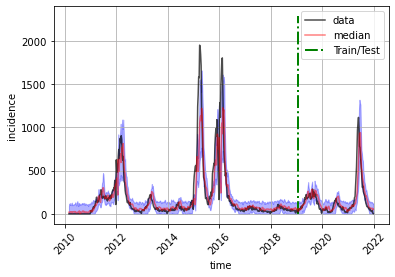

CPU times: user 23min 17s, sys: 2min 2s, total: 25min 19s
Wall time: 17min 42s


,0,1,2,3
mean_absolute_error,37.212959,46.439198,57.769887,72.353412
explained_variance_score,0.930158,0.881615,0.815067,0.730010
mean_squared_error,6545.042528,11110.688754,17351.608179,25282.365173
mean_squared_log_error,0.668860,0.735326,0.774103,0.933134
median_absolute_error,16.916136,19.303452,21.803377,29.062357
r2_score,0.929755,0.880727,0.813722,0.728578


In [8]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = 4, look_back=4, batch_size=1, loss = 'msle')

make_pred(model, city, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 0.75, end_date = '2022-01-01', hidden = 8,
                 predict_n = 4, look_back =  4,
                  label = 'model_msle')

### PGBM model (ml) 

In this case, we use the last 4 observations to predict the next 4. Since a GBT (gradient boosting tree) model has a 1D target, we trained four different models each one specialized in predicting one of the next four observations.

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_{doenca}_predictions.pkl'

The models are saved in the path:
'./saved_models/pgbm/{city}_{doenca}_city_model_{d}_pgbm.pt'
where d is in the arange 1 to 4. 


/opt/anaconda3/envs/alerta_dengue/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 302.4335
Estimator 1/100, Train metric: 276.0659
Estimator 2/100, Train metric: 252.2362
Estimator 3/100, Train metric: 230.4348
Estimator 4/100, Train metric: 210.8006
Estimator 5/100, Train metric: 193.1147
Estimator 6/100, Train metric: 176.9166
Estimator 7/100, Train metric: 162.3206
Estimator 8/100, Train metric: 148.7836
Estimator 9/100, Train metric: 136.5202
Estimator 10/100, Train metric: 125.4234
Estimator 11/100, Train metric: 115.2804
Estimator 12/100, Train metric: 106.0069
Estimator 13/100, Train metric: 97.5694
Estimator 14/100, Train metric: 89.8201
Estimator 15/100, Train metric: 82.7365
Estimator 16/100, Train metric: 76.2699
Estimator 17/100, Train metric: 70.2872
Estimator 18/100, Train metric: 64.7069
Estimator 19/100, Train metric: 59.6004
Estimator 20/100, Train metric: 54.9786
Estimator 21/100, Train metric: 50.8184
Estimator 22/100, Train metric: 46.9218
Estimator 23/100, Train metric: 43.4762
Estimator 24/100, Train metric: 40.22

Estimator 9/100, Train metric: 142.0111
Estimator 10/100, Train metric: 131.1867
Estimator 11/100, Train metric: 121.1975
Estimator 12/100, Train metric: 111.9977
Estimator 13/100, Train metric: 103.6003
Estimator 14/100, Train metric: 96.0043
Estimator 15/100, Train metric: 88.5939
Estimator 16/100, Train metric: 81.9461
Estimator 17/100, Train metric: 76.0429
Estimator 18/100, Train metric: 70.5287
Estimator 19/100, Train metric: 65.5186
Estimator 20/100, Train metric: 60.9579
Estimator 21/100, Train metric: 56.8608
Estimator 22/100, Train metric: 53.1321
Estimator 23/100, Train metric: 49.7325
Estimator 24/100, Train metric: 46.6016
Estimator 25/100, Train metric: 43.4619
Estimator 26/100, Train metric: 40.5934
Estimator 27/100, Train metric: 38.0126
Estimator 28/100, Train metric: 35.6785
Estimator 29/100, Train metric: 33.4576
Estimator 30/100, Train metric: 31.4304
Estimator 31/100, Train metric: 29.4099
Estimator 32/100, Train metric: 27.7086
Estimator 33/100, Train metric: 26.0

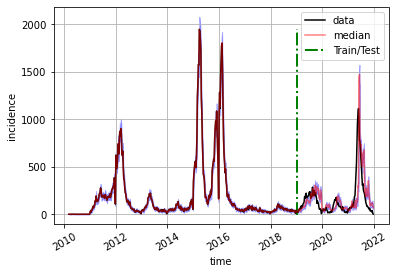

CPU times: user 9min 15s, sys: 1min 14s, total: 10min 29s
Wall time: 1min 41s


In [2]:
%%time

city = 2611606
state = 'PE'
predict_n = 4
look_back = 4


preds, preds25, preds975, X_train, targets = qf_prediction(city, state, predict_n = predict_n, look_back = look_back, doenca = 'dengue', ratio = 0.75, ini_date = None, end_date = '2022-01-01')
   

### Comparing the Neural and ML model 

In this section we compare the performance of the ML and NN model. 

In [3]:
with open(f'./predictions/lstm/lstm_2611606_dengue_model_msle.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{city}_{doenca}_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

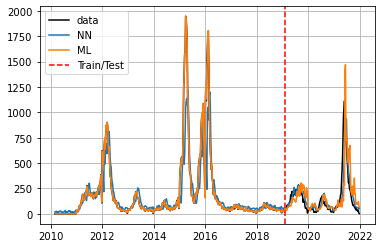

In [4]:
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.axvline(data_ml['dates'][data_ml['train_size']], color = 'red', ls = '--', label = 'Train/Test') # refered to the ML model 

plt.grid()
plt.legend()
plt.show()

Let's compare the error of this models in the test data: 

In [5]:
print('NN error (RMSE):', mse(data_nn['target'][data_nn['xdata'].shape[0]:, -1] * data_nn['factor'], data_nn['pred'].iloc[data_nn['xdata'].shape[0]:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4+ data_ml['train_size']:], data_ml['preds'][data_ml['train_size']:], squared = False))

NN error (RMSE): 115.14933319357276
ML error (RMSE): 175.5405173041297


Looking at the error above we can see that besides comsume more time training, the neural network model (nn) outperform the machine learning model (ml)

We will know use this models to predict the chik outbreak in 2021. In order to do this, we will retrain the nn model and the ml model using the dengue data up to '2021-01-01' and apply the model in the chik data between '2021-01-01' and '2022-01-01'

The label parameter is used as a flag to make difference, if necessary, between the models saved, since this model takes a lot of time to be trained


Compilation Time :  0.031641244888305664
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
________________

2022-08-17 19:58:53.131115: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


462/462 [==============================] - 12s 25ms/sample - loss: 0.0136 - accuracy: 0.2468 - mape: 5334292.0000 - mse: 0.0241 - val_loss: 0.0041 - val_accuracy: 0.1613 - val_mape: 126.5310 - val_mse: 0.0063
Epoch 2/100
462/462 [==============================] - 35s 76ms/sample - loss: 0.0057 - accuracy: 0.2511 - mape: 800300.6875 - mse: 0.0110 - val_loss: 0.0024 - val_accuracy: 0.2774 - val_mape: 73.4538 - val_mse: 0.0039
Epoch 3/100
462/462 [==============================] - 30s 65ms/sample - loss: 0.0051 - accuracy: 0.2771 - mape: 1519950.3750 - mse: 0.0103 - val_loss: 0.0015 - val_accuracy: 0.3613 - val_mape: 68.8156 - val_mse: 0.0023
Epoch 4/100
462/462 [==============================] - 84s 183ms/sample - loss: 0.0050 - accuracy: 0.2857 - mape: 922857.6875 - mse: 0.0103 - val_loss: 0.0023 - val_accuracy: 0.3419 - val_mape: 70.7679 - val_mse: 0.0037
Epoch 5/100
462/462 [==============================] - 96s 208ms/sample - loss: 0.0047 - accuracy: 0.2619 - mape: 705548.3125 - mse:

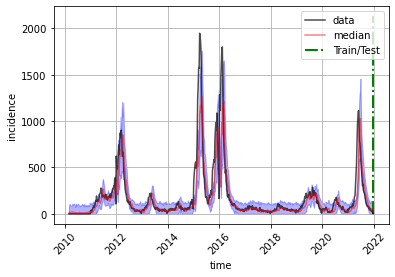

CPU times: user 18min 16s, sys: 1min 11s, total: 19min 28s
Wall time: 14min 4s


,0,1,2,3
mean_absolute_error,44.061906,53.525151,61.769687,74.680357
explained_variance_score,0.924781,0.880239,0.807782,0.711540
mean_squared_error,7950.036715,12393.381112,18938.963862,27731.456584
mean_squared_log_error,0.865547,1.001771,0.472485,0.646609
median_absolute_error,24.910571,26.970962,23.798945,21.623543
r2_score,0.914676,0.866958,0.796681,0.702285


In [5]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = 4, look_back=4, batch_size=1, loss = 'msle')

make_pred(model, city, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1, end_date = '2022-01-01', hidden = 8,
                 predict_n = 4, look_back =  4,
                  label = 'model_msle_all')

/opt/anaconda3/envs/alerta_dengue/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 278.9421
Estimator 1/100, Train metric: 254.5921
Estimator 2/100, Train metric: 232.5017
Estimator 3/100, Train metric: 212.4780
Estimator 4/100, Train metric: 194.4425
Estimator 5/100, Train metric: 178.1451
Estimator 6/100, Train metric: 163.2175
Estimator 7/100, Train metric: 149.7861
Estimator 8/100, Train metric: 137.6918
Estimator 9/100, Train metric: 126.6319
Estimator 10/100, Train metric: 116.2215
Estimator 11/100, Train metric: 106.9082
Estimator 12/100, Train metric: 98.4675
Estimator 13/100, Train metric: 90.5863
Estimator 14/100, Train metric: 83.2985
Estimator 15/100, Train metric: 76.6872
Estimator 16/100, Train metric: 70.7240
Estimator 17/100, Train metric: 65.2707
Estimator 18/100, Train metric: 60.4885
Estimator 19/100, Train metric: 55.9191
Estimator 20/100, Train metric: 51.7592
Estimator 21/100, Train metric: 48.0076
Estimator 22/100, Train metric: 44.4891
Estimator 23/100, Train metric: 41.2738
Estimator 24/100, Train metric: 38.295

Estimator 9/100, Train metric: 130.5868
Estimator 10/100, Train metric: 120.4828
Estimator 11/100, Train metric: 111.5162
Estimator 12/100, Train metric: 103.3894
Estimator 13/100, Train metric: 95.6463
Estimator 14/100, Train metric: 88.7378
Estimator 15/100, Train metric: 82.3591
Estimator 16/100, Train metric: 76.7160
Estimator 17/100, Train metric: 71.5345
Estimator 18/100, Train metric: 66.7092
Estimator 19/100, Train metric: 62.3298
Estimator 20/100, Train metric: 58.0820
Estimator 21/100, Train metric: 54.2496
Estimator 22/100, Train metric: 50.6348
Estimator 23/100, Train metric: 47.3764
Estimator 24/100, Train metric: 44.4925
Estimator 25/100, Train metric: 41.8071
Estimator 26/100, Train metric: 39.4427
Estimator 27/100, Train metric: 37.2198
Estimator 28/100, Train metric: 35.2683
Estimator 29/100, Train metric: 33.3796
Estimator 30/100, Train metric: 31.5647
Estimator 31/100, Train metric: 29.9379
Estimator 32/100, Train metric: 28.4398
Estimator 33/100, Train metric: 27.01

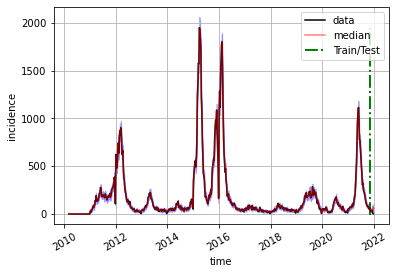

In [2]:


city = 2611606
state = 'PE'
horizon = 4
lookback = 4


preds, preds25, preds975, X_train, targets, data_lag = qf_prediction(city, state, horizon, lookback, doenca = 'dengue', split = 0.99, ini_date = None, end_date = '2022-01-01')
   

Apply the ml model in chik:

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_chik_cross_predictions.pkl'

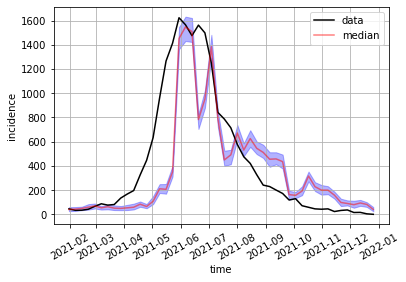

In [16]:
city = 2611606
state = 'PE'
horizon = 4
lookback = 4
ini_date = '2021-01-01'
end_date = '2022-01-01'

preds, preds25, preds975, X_data, targets, data_lag = cross_dengue_chik_prediction(city, state, horizon, lookback, ini_date = ini_date, end_date = end_date)
    

Apply the NN model into the chik data:

The predictions is saved in the path: './predictions/lstm/lstm_{city}_dengue_model_chik_predictions.pkl'

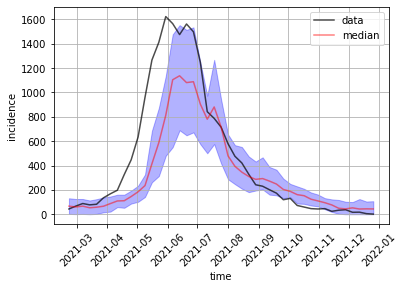

CPU times: user 21.7 s, sys: 1.2 s, total: 22.9 s
Wall time: 12.2 s


In [17]:
%%time
city_name = 'Recife'
city = 2611606
metrics = apply_dengue_chik(city_name, city, ini_date = '2021-01-01', 
                     end_date = '2022-01-01', look_back = 4,
                     predict_n = 4,  label_m = f'model_msle' )

Compare the predictions:

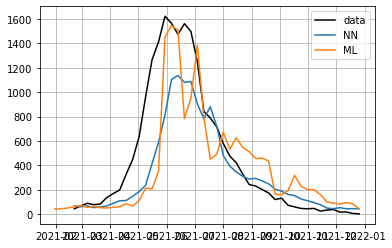

In [19]:
with open(f'./predictions/lstm/lstm_{city}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{city}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.show()

Compute the RMSE error: 

In [20]:

print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

NN error (RMSE): 293.99785164733055
ML error (RMSE): 323.41730753337606


### Transfer learning 

Here we use the transfer learning technique to improve the performance of the predictions of the dengue model in the chik data. To do this, we retrain the output layer of the dengue model, and after it, retrain the model (all the layers, that's the fine tunning step). In this step, we need to pay attention to overfitting. It can be necessary to decrease the learning rate. 

We use the transfer learning technique since it is not possible to train a good ml or nn model with few observations, as in the case of the  chik outbreak in Recife in 2021. 

2022-08-17 17:15:58.992689: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-17 17:15:58.993270: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Compilation Time :  0.028649091720581055
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 36
Non-trainable params: 1,824
_________________

2022-08-17 17:16:03.044497: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


10/10 [==============================] - 4s 376ms/sample - loss: 0.0061 - accuracy: 0.6000 - mape: 88.9527 - mse: 0.0072
Epoch 2/100
10/10 [==============================] - 0s 12ms/sample - loss: 0.0050 - accuracy: 0.6000 - mape: 66.5111 - mse: 0.0060
Epoch 3/100
10/10 [==============================] - 0s 12ms/sample - loss: 0.0042 - accuracy: 0.5000 - mape: 52.5341 - mse: 0.0051   
Epoch 4/100
10/10 [==============================] - 0s 14ms/sample - loss: 0.0035 - accuracy: 0.7000 - mape: 49.0629 - mse: 0.0043
Epoch 5/100
10/10 [==============================] - 0s 17ms/sample - loss: 0.0030 - accuracy: 0.5000 - mape: 44.9403 - mse: 0.0037
Epoch 6/100
10/10 [==============================] - 0s 18ms/sample - loss: 0.0028 - accuracy: 0.7000 - mape: 45.2668 - mse: 0.0035
Epoch 7/100
10/10 [==============================] - 0s 15ms/sample - loss: 0.0026 - accuracy: 0.6000 - mape: 47.3137 - mse: 0.0032
Epoch 8/100
10/10 [==============================] - 0s 17ms/sample - loss: 0.0022 -

2022-08-17 17:16:10.044468: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


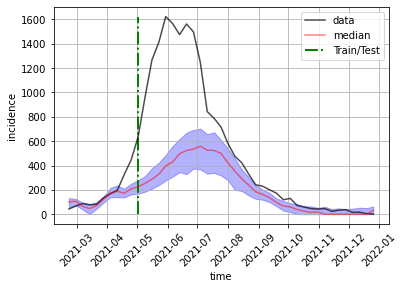

In [3]:

city_name = 'Recife'
city = 2611606
transf_chik_pred(city_name, city, ini_date = '2021-01-01', end_train_date = '2021-05-01',  
                            end_date = '2022-01-01', filename = './saved_models/lstm/trained_2611606_model_model_msle_all.h5',  epochs =100, features = 11,  
                            predict_n = 4, look_back = 4, loss = 'msle', validation_split = 0.0,
                            label = f'transf_chik')

### Retrain the dengue model with a custom loss function 

To specialize our lstm dengue model to predict better the peak of cases we propose a custom loss function. This function gives a weight of 10 to the predictions of ascending cases in the train data. 

This weight is given to the observations in the training data, where the fourth value is bigger than the second value of the target data. (Remember it is an array of length four since we forecast the next 4 observations).  

In [7]:
from lstm import custom_loss_msle

Compilation Time :  0.043718814849853516
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
________________

2022-08-18 08:45:59.179809: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


462/462 [==============================] - 12s 27ms/sample - loss: 0.0855 - accuracy: 0.2273 - mape: 7599338.0000 - mse: 0.0278 - val_loss: 0.0316 - val_accuracy: 0.3097 - val_mape: 219.0244 - val_mse: 0.0092
Epoch 2/100
462/462 [==============================] - 6s 13ms/sample - loss: 0.0399 - accuracy: 0.2835 - mape: 3912849.2500 - mse: 0.0137 - val_loss: 0.0155 - val_accuracy: 0.3290 - val_mape: 106.8229 - val_mse: 0.0070
Epoch 3/100
462/462 [==============================] - 28s 60ms/sample - loss: 0.0243 - accuracy: 0.3203 - mape: 1450820.0000 - mse: 0.0124 - val_loss: 0.0177 - val_accuracy: 0.2710 - val_mape: 76.0170 - val_mse: 0.0059
Epoch 4/100
462/462 [==============================] - 17s 37ms/sample - loss: 0.0256 - accuracy: 0.2641 - mape: 2626109.5000 - mse: 0.0110 - val_loss: 0.0122 - val_accuracy: 0.3419 - val_mape: 135.0804 - val_mse: 0.0077
Epoch 5/100
462/462 [==============================] - 23s 50ms/sample - loss: 0.0246 - accuracy: 0.3095 - mape: 1727524.2500 - ms

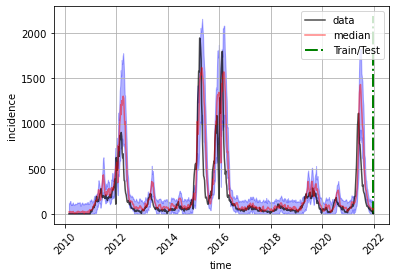

CPU times: user 25min, sys: 1min 41s, total: 26min 42s
Wall time: 19min 36s


,0,1,2,3
mean_absolute_error,49.000748,64.069334,81.225058,106.455178
explained_variance_score,0.888362,0.816818,0.724530,0.551730
mean_squared_error,10572.181659,17646.416446,27138.647401,46000.280280
mean_squared_log_error,0.735356,0.608132,0.809372,1.001889
median_absolute_error,19.027150,19.157813,25.618399,34.946984
r2_score,0.886533,0.810567,0.708653,0.506158


In [8]:
%%time
model = build_model(hidden = 8, features = 11, predict_n = 4, look_back=4, batch_size=1, loss = custom_loss_msle(p=10))

make_pred(model, city, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1.0, end_date = '2022-01-01', hidden = 8,
                 predict_n = 4, look_back =  4,
                  label = 'custom_msle')

See the behaviour of this model when applied in the chik data:

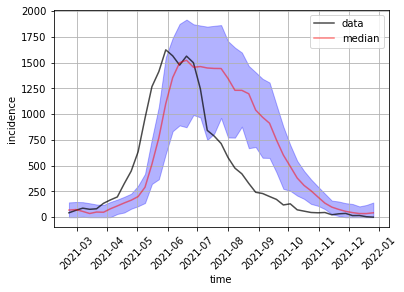

CPU times: user 21.6 s, sys: 1.48 s, total: 23.1 s
Wall time: 12.8 s


In [10]:
%%time
city_name = 'Recife'
city = 2611606
metrics = apply_dengue_chik(city_name, city, ini_date = '2021-01-01', 
                     end_date = '2022-01-01', look_back = 4,
                     predict_n = 4,  label_m = f'model_custom_msle' )

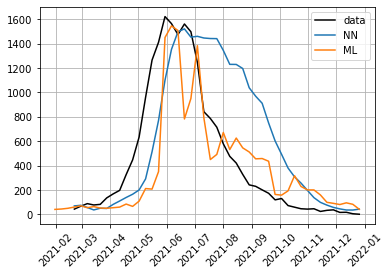

In [11]:
with open(f'./predictions/lstm/lstm_{city}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{city}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [12]:
print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

NN error (RMSE): 438.23412076833125
ML error (RMSE): 323.41730753337606


Apply the transfer learning technique using this new trained model:

Compilation Time :  0.03272390365600586
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4, 11)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
Total params: 1,860
Trainable params: 36
Non-trainable params: 1,824
________________

2022-08-18 09:29:38.287261: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


10/10 [==============================] - 4s 423ms/sample - loss: 0.0618 - accuracy: 0.1000 - mape: 90.5021 - mse: 0.0074
Epoch 2/100
10/10 [==============================] - 0s 12ms/sample - loss: 0.0562 - accuracy: 0.1000 - mape: 82.4759 - mse: 0.0068
Epoch 3/100
10/10 [==============================] - 0s 12ms/sample - loss: 0.0519 - accuracy: 0.2000 - mape: 77.1793 - mse: 0.0062
Epoch 4/100
10/10 [==============================] - 0s 13ms/sample - loss: 0.0480 - accuracy: 0.3000 - mape: 72.7686 - mse: 0.0058
Epoch 5/100
10/10 [==============================] - 0s 15ms/sample - loss: 0.0417 - accuracy: 0.7000 - mape: 66.0676 - mse: 0.0051
Epoch 6/100
10/10 [==============================] - 0s 19ms/sample - loss: 0.0383 - accuracy: 0.7000 - mape: 64.9471 - mse: 0.0047
Epoch 7/100
10/10 [==============================] - 0s 17ms/sample - loss: 0.0344 - accuracy: 0.8000 - mape: 65.2634 - mse: 0.0042
Epoch 8/100
10/10 [==============================] - 0s 17ms/sample - loss: 0.0342 - ac

10/10 [==============================] - 0s 29ms/sample - loss: 0.0105 - accuracy: 0.7000 - mape: 50.0267 - mse: 0.0014
Epoch 63/100
10/10 [==============================] - 0s 26ms/sample - loss: 0.0113 - accuracy: 0.7000 - mape: 50.8263 - mse: 0.0015
Epoch 64/100
10/10 [==============================] - 0s 35ms/sample - loss: 0.0124 - accuracy: 0.7000 - mape: 57.0520 - mse: 0.0016
Epoch 65/100
10/10 [==============================] - 0s 39ms/sample - loss: 0.0113 - accuracy: 0.7000 - mape: 52.1863 - mse: 0.0015
Epoch 66/100
10/10 [==============================] - 0s 44ms/sample - loss: 0.0099 - accuracy: 0.7000 - mape: 48.6336 - mse: 0.0013
Epoch 67/100
10/10 [==============================] - 2s 173ms/sample - loss: 0.0128 - accuracy: 0.7000 - mape: 57.2101 - mse: 0.0017
Epoch 68/100
10/10 [==============================] - 1s 92ms/sample - loss: 0.0123 - accuracy: 0.7000 - mape: 55.5463 - mse: 0.0017
Epoch 69/100
10/10 [==============================] - 0s 20ms/sample - loss: 0.00

2022-08-18 09:30:03.947656: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


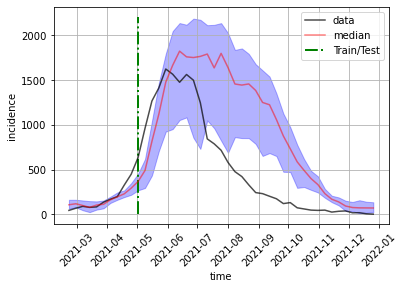

CPU times: user 1min 11s, sys: 5.44 s, total: 1min 16s
Wall time: 49 s


In [13]:
%%time
city_name = 'Recife'
city = 2611606
transf_chik_pred(city_name, city, ini_date = '2021-01-01', end_train_date = '2021-05-01',  
                            end_date = '2022-01-01', filename = './saved_models/lstm/trained_2611606_model_model_custom_msle.h5',  epochs =100, features = 11,  
                            predict_n = 4, look_back = 4, loss = custom_loss_msle(p=10), validation_split = 0.0,
                            label = f'transf_chik')

To apply the transfer learning technique we use as train data the chik data up to '2021-05-01'. We can see that after this day the model has good performance considering the next two months (data between '2021-05-01' and '2021-07-01'). 

To evaluate the improvement in the performance of the model we compute the following skill score: 

$$ SS = 1 - \cfrac{RMSE_{forecast}}{RMSE_{reference}}$$ 

In the formula, the reference represent the error of the model used as reference and the forecast represent the new model that we want to compare the performance. If the SS value is above 0 or new model is better than the reference model, otherwise it's worst. 

In [14]:
def ss(forecast, reference, target):
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)


Comparing the predictions of the NN (neural network), the TL (transfer learning) and the ML (machine learning) model:

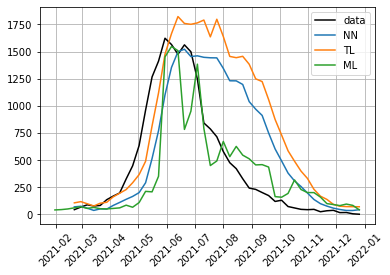

In [15]:
with open(f'./predictions/lstm/lstm_{city}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'./predictions/pgbm/pgbm_{city}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

with open(f'predictions/tl_{city}_transf_chik.pkl', 'rb') as f:
        data_tl = pickle.load(f) # Transfer learning data 
        

plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_tl['indice'][7:],data_tl['pred'].iloc[:,-1] * data_tl['factor'], label = 'TL')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [16]:
from datetime import datetime
ini_index = data_nn['indice'].index(datetime.strptime('2021-05-02', '%Y-%m-%d'))
end_index = data_nn['indice'].index(datetime.strptime('2021-07-04', '%Y-%m-%d'))

print('SS compared to NN:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_nn['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_nn['factor']))
print('SS compared to ML:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_ml['preds'][ data_ml['dates'].index(datetime.strptime('2021-05-02', '%Y-%m-%d')): data_ml['dates'].index(datetime.strptime('2021-07-04', '%Y-%m-%d'))] ))


SS compared to NN: 0.3411314505415046
SS compared to ML: 0.5431539192814108
